# Ups and downs

The following is a write-up for the challenge "Ups and downs" for [Undutmaning 2025](https://undutmaning.ctfd.io/challenges#Ups%20and%20downs-15).

I was sadly not able to solve this challenge while the event was on, but I finished it afterwards to save my pride.

My solution is in best case suboptimal, but the nice part is that you can follow along from first principles (:

In [49]:
import seaborn as sns # Don't judge me.
sns.set_theme(style='whitegrid')

from types import SimpleNamespace
import numpy as np
import struct
import matplotlib.pyplot as plt

So I start out simply with some simple imports and just reading the "challenge.bin".

In [2]:
chall_bin = np.fromfile("C:/Users/aragn/Downloads/challenge.bin", dtype='uint8')
[f'{x:02x}' for x in chall_bin[:12]]

['0b', '77', '87', 'd0', '4c', '40', '2f', '84', '2b', 'e1', 'd2', 'b7']

I googled the first bytes and discover that this is an AC3 synch frame. Nice! How to decode it?

I find this website with some info: http://www.mpucoder.com/DVD/ac3hdr.html

In [3]:
syncword, crc = struct.unpack(">hh", chall_bin[:4])
fs = np.unpackbits(chall_bin[4])
fs[:2], fs[2:]

(array([0, 1], dtype=uint8), array([0, 0, 1, 1, 0, 0], dtype=uint8))

From the table in the link I got the following:

In [4]:
sampling_rate = 44100 # Hz
bit_rate = 96000 # bps
samples_per_sync_frame = 208

In [ ]:
bits = np.unpackbits(chall_bin[5:9])

bsi = SimpleNamespace()
bsi.id = bits[:5]
bsi.mod = bits[5:8]
bsi.acmod = bits[8:11]
bsi.lfeon = bits[11]
bsi.dialnorm = bits[12:17]
bsi.compre = bits[17]
bsi.lancode = bits[18]
bsi.audioprodie = bits[19]
bsi.copyright = bits[20]
bsi.origbs = bits[21]
bsi.timecode1e = bits[22]
bsi.timecode2e = bits[23]
bsi.addbsie = bits[24]

vars(bsi)

And this is around the point where I realize something that I should probably have realized much earlier. Like about an hour earlier, before I even looked up AC3 on Wikipedia, I should have realizes that decoding AC3 is probably going to take a couple of weeks, require reading the standard and or looking at other implementations (which seem to indicate that it is kind of [a pain](https://github.com/kxproject/kx-audio-driver/blob/19d1e856533e475b702121c42fd9463855808947/ac3/parse.c#L334)). And it was probably never intended by the designer of the challenge either.

Instead I realized that I could just use ffmpeg: (And I took down the sampling rate to 8000)

In [ ]:
%%!
ffmpeg -i challenge.ac3 -vcodec copy -acodec pcm_u8 -ar 8000 -ab 128k -ac 1 challenge_8bit.wav -y

Then I just read the converted wave file as bytes. I guess there is a header of some sort here, yolo.

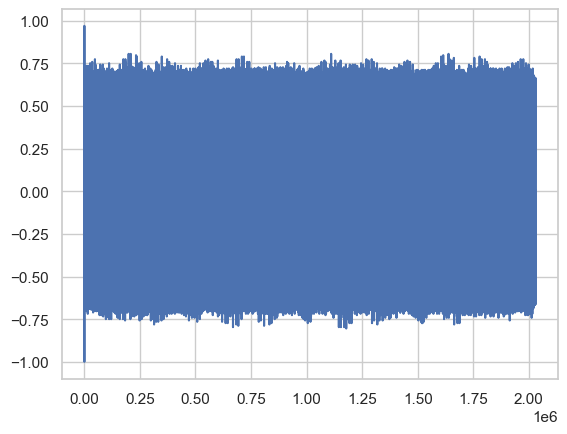

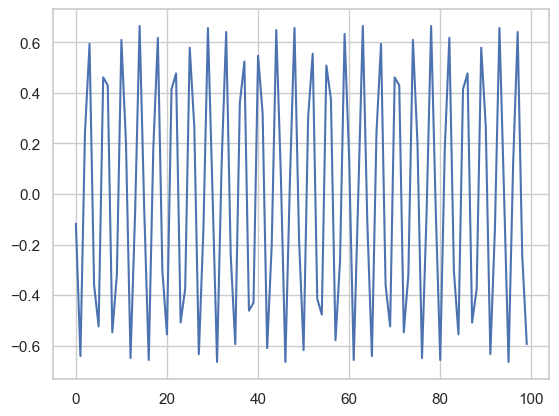

In [50]:
bytes = np.fromfile("challenge_8bit.wav", dtype="uint8")
signal = (bytes - 128.0) / 128-0
sampling_rate = 8000
plt.plot(signal)
plt.figure()
plt.plot(signal[200:300])

It looks like some sort of signal, and since I could hear it much in Audacity it should be in the audible spectrum, without too much noise.

And like always with signals, I create a power spectrum to see if we can learn something about the signal.

f1: 2292.93 Hz
f2: 2123.08 Hz


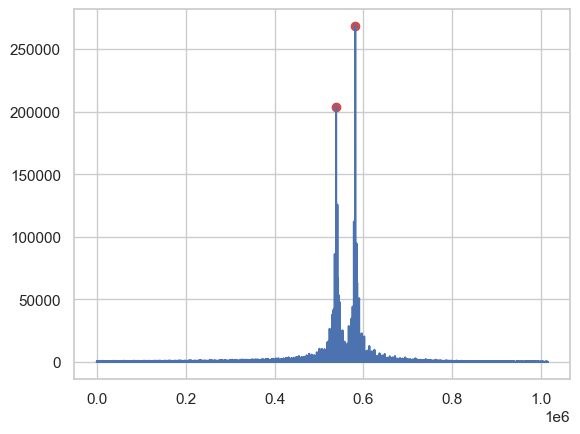

In [11]:
ft = np.fft.fft(signal)

psd = np.abs(ft[:len(ft) //2])
p1 = np.argmax(psd)
p2 = np.argmax(psd[:p1])

f1 = p1 * (sampling_rate / len(ft))
f2 = p2 * (sampling_rate / len(ft))

plt.plot(psd)
plt.scatter([p1, p2], [psd[p1], psd[p2]], c='r', marker='o')

print(f'f1: {f1:02.2f} Hz')
print(f'f2: {f2:02.2f} Hz')

Turns out we have two major frequencies, ~2300 Hz and ~2100 Hz. This alone does not tell me anything. Maybe it should, I am not sure.

However, since the signals seem to be quite clean and separated I am going to separate them roughly with a reverse fft to see if I can make some sense of it. 

C:\Users\aragn\miniconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\aragn\miniconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


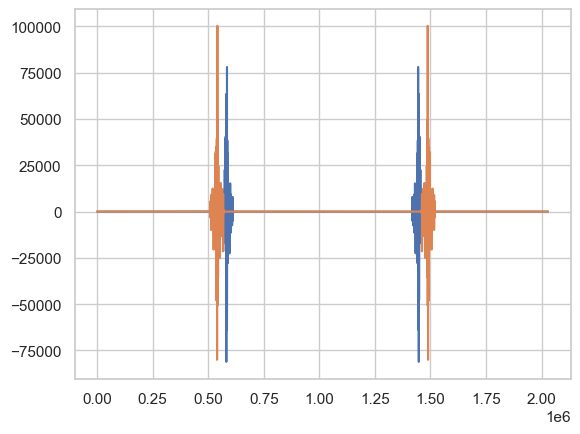

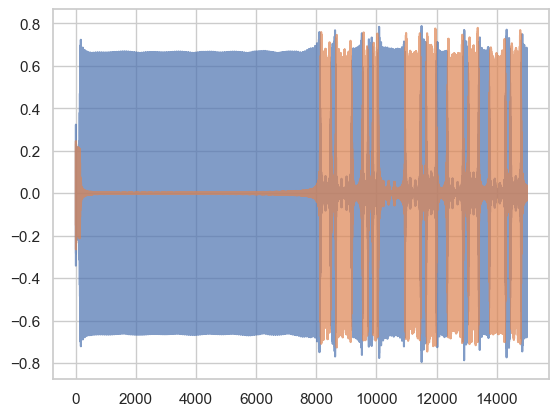

In [12]:
a = np.zeros(len(ft), dtype="complex64")
a[p1-30000:p1+30000] = ft[p1-30000:p1+30000]
a[len(ft)-p1-30000:len(ft)-p1+30000] = ft[len(ft)-p1-30000:len(ft)-p1+30000]
a_ift = np.fft.ifft(a)

b = np.zeros(len(ft), dtype="complex64")
b[p2-30000:p2+30000] = ft[p2-30000:p2+30000]
b[len(ft)-p2-30000:len(ft)-p2+30000] = ft[len(ft)-p2-30000:len(ft)-p2+30000]
b_ift = np.fft.ifft(b)

plt.plot(a)
plt.plot(b)
plt.figure()

s = slice(0, 15000)
plt.plot(b_ift[s], alpha=.7)
plt.plot(a_ift[s], alpha=.7)

It seems like the signal is made up out of pulses of alternating frequencies.

I create a windowed average to smooth the signal and then I create separate the points where b > a.

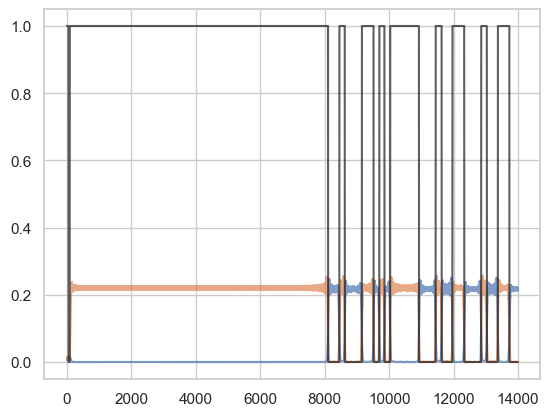

In [13]:
N = 50
a_smooth = np.convolve(a_ift**2, np.ones(N)/N, "valid")
b_smooth = np.convolve(b_ift**2, np.ones(N)/N, "valid")
raw_data = b_smooth > a_smooth

s = slice(0, 14000)
plt.plot(a_smooth[s], alpha=.7)
plt.plot(b_smooth[s], alpha=.7)
plt.plot(raw_data[s], 'k', alpha=.7)

From this signal I can glean that there is some form of periodicity to the pulses.

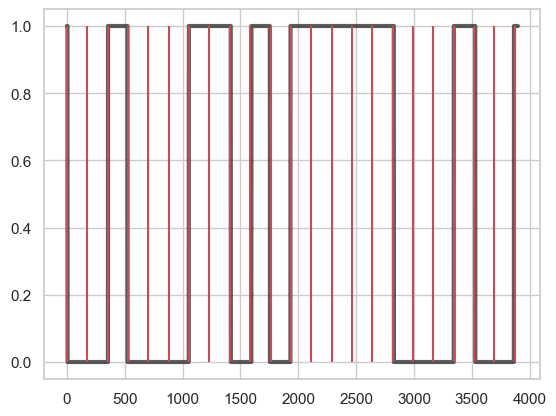

In [31]:
s = slice(8100, 12000)
plt.plot(raw_data[s], 'k', alpha=.7, linewidth=3.0)

width = 176
line_count = (s.stop - s.start) // width + 1
plt.vlines(np.arange(line_count) * width, ymin=0, ymax=1, colors='r')

The width of the thinnest pulses is about 175 samples which corresponds to about (1/8000) * 175 = ~22 ms

Using this width I sample the signal again at 1/175 to get something that should be decodeable.

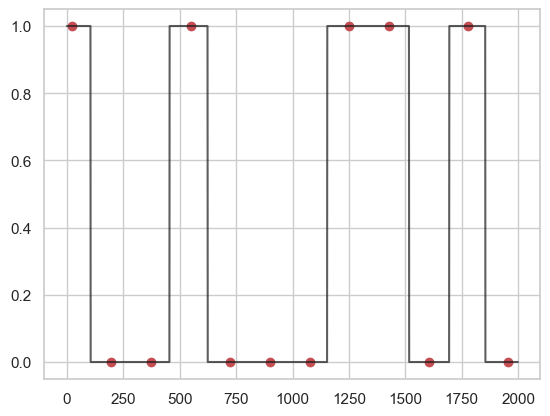

In [36]:
s = slice(8000, 10000)
line_count = (s.stop - s.start) // width + 1
sample_points = np.arange(line_count) * width + 20
samples = raw_data[s][sample_points]
plt.scatter(sample_points, samples, c='r')
plt.plot(raw_data[s], 'k', alpha=.7)

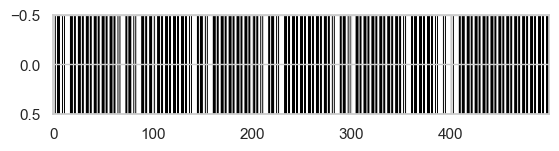

In [37]:
sample_points = np.arange(8000 + 20, len(raw_data), width)
samples = raw_data[sample_points]

plt.imshow(samples[:500].reshape(1, 500), aspect=100, cmap='gray')

Could this be morse code again? Or is this a bar code?

After trying to match these pulses up to morse in some way for far too long I figure that it probably is some other kind of signal. The questions is just what kind of signal.

After googling for a bit I found something called [Baudot code](https://en.wikipedia.org/wiki/Baudot_code).

(In reality I was looking at a lot of different encodings, discarding Baudot several times because I could not figure out how it was encoded in the signal.)

Baudot code is a 5-bit code that has been used for over 100 years. And it could be a good fit, if I could only figure out how this was encoded. Using a lot of ideas I tried to figure out how this encoding worked. Reading as much as I could about Baudot code and AFSK.

But this is basically as far as I was able to get before the end of Undutmaning 2025 :(

My breakthrough came about a week later when I was looking at the problem again. I made the data into an image to visualize the data, and that is when I realized that even though Baudot is a 5 bit code, there is some additional pulses sent for synching.

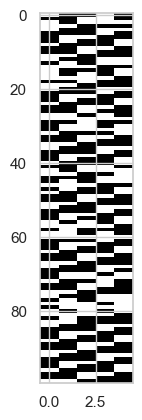

In [38]:
w = 5
h = len(samples) // w
im = samples[:w * h].reshape(len(samples) // w, w)
plt.imshow(im[:100, :], aspect=1/5, cmap='gray')

I realize that there is this zig-zag pattern, so I increase the width to 8.

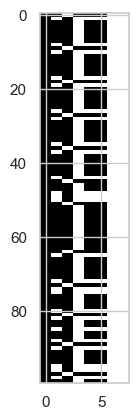

In [39]:
w = 8
h = len(samples) // w
push = 1
im = samples[push:w * h+push].reshape(len(samples) // w, w)
plt.imshow(im[:100, :], aspect=1/3, cmap='gray')

The pattern appeared and I converted it to Baudot.

In [16]:
letters = [
        '\x00', 'E', '\n', 'A', ' ', 'S', 'I', 'U',
        '\r', 'D', 'R', 'J', 'N', 'F', 'C', 'K',
        'T', 'Z', 'L', 'W', 'H', 'Y', 'P', 'Q',
        'O', 'B', 'G', '\0x99', 'M', 'X', 'V', '\0xAA'
    ]

baudot = np.packbits(im[:, 1:6], axis=1, bitorder='little').squeeze()

In [17]:
for i in baudot:
    print(letters[i], end='')


X      X
X      X
X      X
X      X
X      X
  XXX
            
X      X
XX    X
X  X  X
X    XX
X      X
            
XXXX  
X      X
X      X
X      X
X      X
XXXX  
            
X      X
X      X
X      X
X      X
X      X
  XXX  
            
XXXXX
 IHHX     IPHHX   ITPHH X 
IPZPHT X
LPPWTT 
 xAALPPPWT 
LLLPLLLLLLLZLLLLVVZLLVLLLLZLLVLLLLZVVLLLLZLLVLLLLZLLVLLLLZLLVLLLLZLLLLVVZLLLLLLLLLLLLZVLLLLLLVZVLLLLLLVZVLLLLLLVZVLLLLLLVZVLLLLLLVZLLVVVLLZLLLLLLLLLLLLZVVVVLLZVLLLLLLVZVLLLLLLVZVVVVLLZVLLLLLLLLLLZVLLLLLLLLLLZLLLLLLLLLLLLLLZLLLLLLLLLLLLLLZLLLLLLLLLLLLLLZLLLLLLLLLLLLLLZLLLLLLLLLLLLLLZLLLLLLLLLLLLLLZLLLLLLLLLLLLLLZVVVVVZLLLLLLLLLLLLZVVVVLLZVLLLLLLVZVLLLLLLVZVLLLLLLVZVLLLLLLVZVVVVLLZZLLVVVLLZVLLLLLLVZVLLLLLLVZVLLLLLLVZVLLLLLLVZLLVVVLLZLLLLLLLLLLLLZVLLLLLLVZVLLLLLLVZVLLLLLLVZVLLVLLVZVVLLVVZVLLLLLLVZLLLLLLLLLLLLZVLLLLLLVZVVLLLLVZVLLVLLVZVLLLLVVZVLLLLLLVZLTLWWGGLLTTLWWBGGLTTZW x99 x99GGTTTTW x99 x99 x99GOTZZB x99 x99 x99OBTZZB x99 x99 x99OOBZBBBOBBBBBBBBBBBBBBOBBBBBBBBBBBBBBOBBBBBBBBBBBB

And this is where I found the first part of the flag.

The rest of the flag can be recovered by moving the starting point by one or two bits. I guess this is because the width of each 5-bit sequence is not exactly eight widths long all the time, and there is some way to recover from desynchronization.

After another deep dive I learn that the last three bytes fills that function and that the next "word" comes after the first break after at least 2 widths of "space" frequency signal.

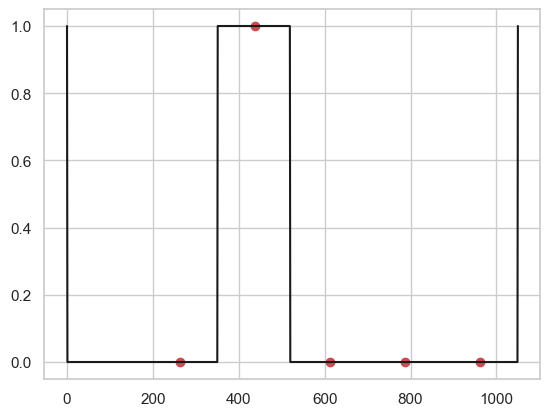

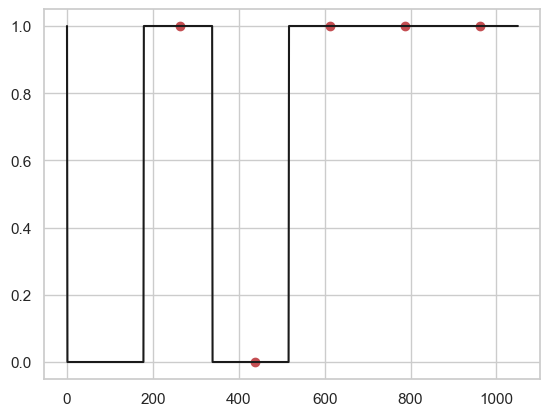

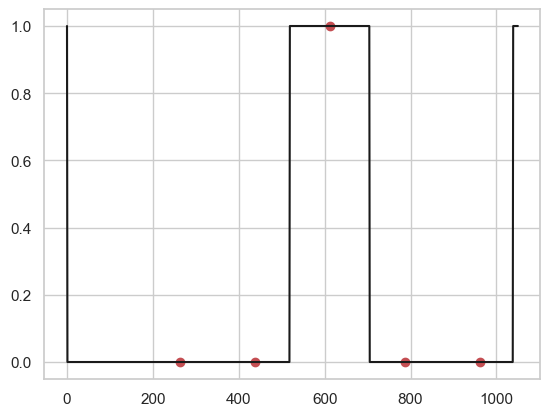

<Figure size 640x480 with 0 Axes>

In [42]:
width = 175
window_size = 6 * width
sample_pts = np.arange(width + width // 2, window_size, width)

i = 100  # skip first 100 samples due to WAV header
count = 0
sync = True
while i < len(raw_data):
    if raw_data[i] == 0 and sync == True:
        sync = False
        samples = raw_data[i:][sample_pts]
        plt.plot(raw_data[i-1:i+window_size], c='k')
        plt.scatter(sample_pts, samples, c='r')
        plt.figure()
        i += width * 7
        count += 1
        if count > 2:
            break
    
    elif raw_data[i] > 0 and sync == False:
        sync = True
        
    elif raw_data[i] > 0 and sync == True:
        # Wait for next sync pulse
        pass

    i += 1

And finally after syncing I get the flag.

In [ ]:
sync = True

width = 175
window_size = 6 * width
sample_pts = np.arange(width + width // 2, window_size, width)

i = 100  # skip first 100 samples due to WAV header
while i < len(raw_data):

    if raw_data[i] == 0 and sync == True:
        sync = False
        samples = raw_data[i:][sample_pts]
        c = np.packbits(samples, bitorder='little').squeeze()
        print(letters[c], end='')
        
        i += window_size
    
    elif raw_data[i] > 0 and sync == False:
        sync = True
        
    elif raw_data[i] > 0 and sync == True:
        # Wait for next sync pulse
        pass

    i += 1

However, this is when I realized that just like I did not have to manually implement AC3 decoding, I probably did not have to to all of this signal processing. 

Turns out there is a tool called [minimodem](https://github.com/kamalmostafa/minimodem) among others that can do this. And so the solution could easily be shortened to the following two commands.

In [90]:
%%!
minimodem -r rtty -f challenge_8bit.wav -S 2300 -M 2100

["'minimodem' is not recognized as an internal or external command,",
 'operable program or batch file.']

If I only had only thought of that a little earlier.

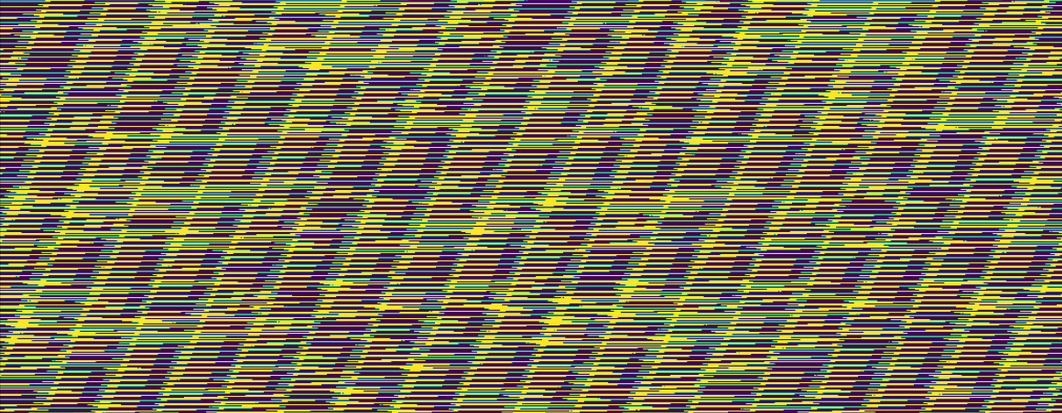